# Assignment 3
# Vowel Synthesis with Wavenet

In this notebook we explore a modified version (deterministic output layer) of the WaveNet architecture and try to
synthesize a vowel sound.

First, the imports.

In [1]:
%reload_ext autoreload
%autoreload 2
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
# torchaudio.set_audio_backend('soundfile')
from tqdm.notebook import tqdm

from src.models.wavenet_deterministic import WaveNetDeterministic
# from src.models.conditional_wavenet_deterministic import ConditionalWaveNetDeterministic
from src.utils.plotting import init_plot_style

init_plot_style()

Here we load the training data (vowel recordings) and convert the sample rate accordingly.

In [61]:
files = [#'../../data/audio/vowels/vowels-a-sophie.wav',]
         '../../data/audio/vowels/vowels-e-sophie.wav',]
         #'../../data/audio/vowels/vowels-i-sophie.wav',
         #'../../data/audio/vowels/vowels-o-sophie.wav',
         #'../../data/audio/vowels/vowels-u-sophie.wav']

# prepare data
sample_rate = 8000

min_len = None
data = []
for file in files:
    vowel, orig_sample_rate = torchaudio.load(file)
    vowel_crop = vowel[:,5000::]
    resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=sample_rate)
    vowel = resampler(vowel_crop)
    min_len = vowel.shape[-1] if min_len is None or vowel.shape[-1] < min_len else min_len
    data.append(vowel)
print(vowel.shape)
data = torch.stack([seq[:, :min_len] for seq in data])
print(f'Sequence length is {data.shape[-1]} samples ({data.shape[-1] / sample_rate:.2f}s)')
print(data.shape)
ipd.Audio(data[0].squeeze().numpy(), rate=sample_rate)

torch.Size([1, 37500])
Sequence length is 37500 samples (4.69s)
torch.Size([1, 1, 37500])


Let's also have a look at the time domain vowel signal(s).

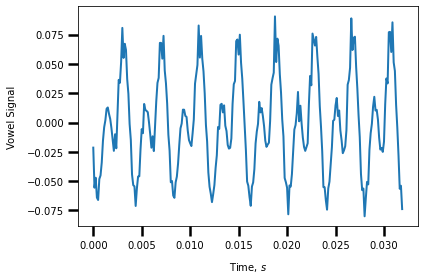

In [62]:
%matplotlib inline

plt.figure()
i = 0
plt.plot(torch.arange(256) / sample_rate, data[0].squeeze()[256*i:256*(i+1)])
plt.xlabel('Time, $s$')
plt.ylabel('Vowel Signal')
plt.tight_layout()

Next, we create an instance of our modified WaveNet. We also generate the context vectors and the targets for training.

In [63]:
# we assume all vowels are different, i.e. each waveform has its own context
#context_size = data.shape[0]
#context = F.one_hot(torch.arange(0, context_size)).float()

# create the wavenet
wavenet = WaveNetDeterministic(blocks_per_cell=12, num_cells=1, num_kernels=32)
# wavenet = ConditionalWaveNetDeterministic(blocks_per_cell=8, num_cells=1, num_kernels=20, context_size=context_size)
print(f'Receptive Field of WaveNet is {wavenet.receptive_field} samples')

# create target tensor
targets = data[:, :, wavenet.receptive_field + 1:]
targets.shape

been in init
kernel size 2
Receptive Field of WaveNet is 8192 samples


torch.Size([1, 1, 29307])

Now we can train and evaluate our model.

been in init
kernel size 2


  0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 50/500(10%)]	Loss: 0.00106
Training epoch 100/500(20%)]	Loss: 0.00076
Training epoch 150/500(30%)]	Loss: 0.00060
Training epoch 200/500(40%)]	Loss: 0.00039
Training epoch 250/500(50%)]	Loss: 0.00027
Training epoch 300/500(60%)]	Loss: 0.00018
Training epoch 350/500(70%)]	Loss: 0.00024
Training epoch 400/500(80%)]	Loss: 0.00012
Training epoch 450/500(90%)]	Loss: 0.00014
Training epoch 500/500(100%)]	Loss: 0.00013


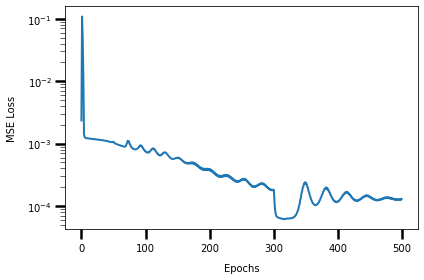

In [64]:
wavenet = WaveNetDeterministic(blocks_per_cell=12, num_cells=1, num_kernels=32)

# training setup
log_interval = 50  # log training stats after so many epochs
num_epochs = 500  # number of epochs to train

# define and parameterize the optimizer
optimizer = optim.RMSprop(wavenet.parameters(), lr=5e-4, weight_decay=1e-8)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [10, 50, 300, 800, 2000], gamma=0.8)

# set up the progress bar
with tqdm(total=num_epochs) as pbar:
    # train the network
    loss_list = []
    for epoch in range(1, num_epochs + 1):
        wavenet.train()  # puts the model into train mode

        # compute training loss
        predictions = wavenet(data)[:, :, wavenet.receptive_field:-1]
        # predictions = wavenet(data, context)[:, :, wavenet.receptive_field:-1]
        train_loss = torch.nn.functional.mse_loss(predictions, targets)

        # optimize the network parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # record the training set MSE after each epoch
        loss_list.append(train_loss.detach().numpy())

        # print training stats
        print(f'Training epoch {epoch}/{num_epochs}'
              f'({100. * epoch / num_epochs:.0f}%)]\tLoss: {train_loss.item():.5f}', end='\r')
        if epoch % log_interval == 0:
            print(''
                  )
        # update progress bar
        pbar.update(1.)

        scheduler.step()

# plot training loss over the iterations
plt.figure()
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.semilogy()
plt.tight_layout()


Let's see how well our WaveNet fits a given vowel sound by comparing parts of both signals in time domain.

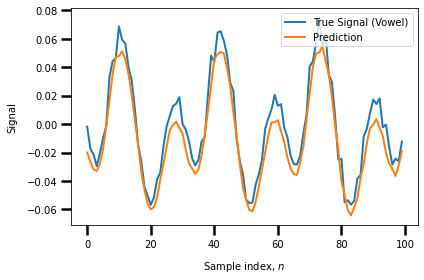

In [66]:
idx = 0 # select sample from the training set
prediction = wavenet(data[idx, :, :].unsqueeze(0))
# prediction = wavenet(data[idx, :, :].unsqueeze(0), context[idx, :].unsqueeze(0))

# plot params
offset = wavenet.receptive_field
span = 100

# plot the signals
plt.figure()
plt.plot(data[idx, :, :].squeeze()[offset + 1:offset + 1 + span], label='True Signal (Vowel)')
plt.plot(prediction.squeeze().detach()[offset:offset + span], label='Prediction')
plt.xlabel('Sample index, $n$')
plt.ylabel('Signal')
plt.legend()
plt.tight_layout()

Can you hear a difference between the original recording and WaveNet's prediction?

In [67]:
# ipd.Audio(data[idx].squeeze().detach().numpy(), rate=sample_rate)
ipd.Audio(prediction.squeeze().detach().numpy(), rate=sample_rate)

Finally, we can generate a vowel signal with our trained wavenet!

In [68]:
#ctx = torch.tensor([[0.9, 0, 0, 0, 0]]).float()
with torch.no_grad():
    signal = wavenet.generate(1000, data[0, :, :wavenet.receptive_field].unsqueeze(0))
    # signal = wavenet.generate(3000, ctx, data[0, :, :wavenet.receptive_field].unsqueeze(0))

been in generate
conv_buffer shape:  torch.Size([1, 32, 3])
conv_buffer shape:  torch.Size([1, 32, 5])
conv_buffer shape:  torch.Size([1, 32, 9])
conv_buffer shape:  torch.Size([1, 32, 17])
conv_buffer shape:  torch.Size([1, 32, 33])
conv_buffer shape:  torch.Size([1, 32, 65])
conv_buffer shape:  torch.Size([1, 32, 129])
conv_buffer shape:  torch.Size([1, 32, 257])
conv_buffer shape:  torch.Size([1, 32, 513])
conv_buffer shape:  torch.Size([1, 32, 1025])
conv_buffer shape:  torch.Size([1, 32, 2049])


It's also interesting to look a the generated waveform in time domain.

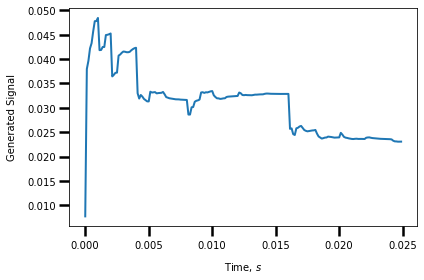

In [69]:
offset = 0
span = 200
plt.figure()
plt.plot((offset + torch.arange(span)) / sample_rate, signal.squeeze().detach()[offset:offset+span])
plt.xlabel('Time, $s$')
plt.ylabel('Generated Signal')
plt.tight_layout()


Well, our WaveNet does not sound like Caruso, but still..
We repeat the generated signal for convenience.

In [70]:
initial_cutoff = 0
num_repetitions = 10

signal = signal.squeeze()[initial_cutoff:]
signal_repeated = signal.view(1, -1).repeat(1, 1 + num_repetitions)
ipd.Audio(signal_repeated.detach().numpy(), rate=sample_rate)

